# Albumentation

TL;DR : Data_augment is powerful, but won't be used here for various reasons :

1- Our models are trained using only 10% of dataset, and already need almost 24 hours each to train \
2- Data augment have been tried, but local machine seems unable to run data-augment pipeline

In [2]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil

import tensorflow as tf
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models import get_preprocessing

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from keras.metrics import IoU
from tensorflow.keras.metrics import MeanIoU

import albumentations as A
import cv2

from metrics_and_loss import CombinedLoss, M_IoUMetric

Segmentation Models: using `tf.keras` framework.


C:\Users\kanam\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Paramètres
IMG_HEIGHT = 512
IMG_WIDTH = 512
NUM_CLASSES = 8
BATCH_SIZE = 8

# Albumentations - train & validation
albumentations_transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([
        A.RandomFog(p=0.25),         # If OneOf is chosen, RandomFog has a 25% chance within the OneOf block
        A.RandomSnow(p=0.25),           
        A.RandomRain(p=0.25), 
        A.RandomSunFlare(p=0.25)
    ], p=0.3), # The OneOf block has a 30% chance to be considered
    A.Resize(IMG_HEIGHT, IMG_WIDTH)
],seed=42, additional_targets={'mask': 'mask'}) # added seed for reproducibility

albumentations_transform_val = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH)
], additional_targets={'mask': 'mask'})

# Chargement avec OpenCV + Albumentations (appelée par tf.py_function)
def read_image_and_mask(img_path, mask_path, augment=True):
    img_path = img_path.numpy()
    mask_path = mask_path.numpy()
    
    #debug funcs
    if isinstance(img_path, bytes):
        print("Traitement de l'image :", img_path.decode('utf-8'), "is utf decoded")
        print("Traitement de l'image :", mask_path.decode('utf-8'), "is utf decoded")
    else:
        print("Traitement de l'image :", img_path)


    if isinstance(img_path, bytes):
        img_path = img_path.decode('utf-8')
    if isinstance(mask_path, bytes):
        mask_path = mask_path.decode('utf-8')
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    

    #checker if image / mask is available
    if image is None:
        raise ValueError(f"Impossible de lire l'image : {img_path}")
    if mask is None:
        raise ValueError(f"Impossible de lire le masque : {mask_path}")
        
    if augment:
        augmented = albumentations_transform_train(image=image, mask=mask)
    else:
        augmented = albumentations_transform_val(image=image, mask=mask)

    image = augmented["image"] / 255.0
    mask = augmented["mask"]

    mask_one_hot = np.zeros((IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES), dtype=np.uint8)
    for i in range(NUM_CLASSES):
        mask_one_hot[:, :, i] = (mask == i).astype(np.uint8)
        
    #print("Somme des pixels image :", np.sum(image))
    #print("Somme des pixels masque :", np.sum(mask))
    print("Image OK : ", img_path)

    return image.astype(np.float32), mask_one_hot.astype(np.float32)

# Wrapper pour tf.data
def load_image_mask(img_path, mask_path, augment=True):
    image, mask = tf.py_function(
        func=lambda x, y: read_image_and_mask(x, y, augment=augment),
        inp=[img_path, mask_path],
        Tout=[tf.float32, tf.uint8]
    )
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES])
    return image, mask

def get_dataset(image_dir, mask_dir, augment=False):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

    assert len(image_paths) == len(mask_paths), "Mismatch entre le nombre d'images et de masques !"

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image_mask(x, y, augment), num_parallel_calls=1) #problem is not from threading count
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [4]:
def read_image_and_mask(img_path, mask_path, augment=True):
    #print("Image path is :", img_path)
    img_path = img_path.numpy()
    mask_path = mask_path.numpy()
    #print("Numpy Image path is :", img_path)
    
    #debug funcs
    '''if isinstance(img_path, bytes):
        print("Traitement de l'image :", img_path.decode('utf-8'), "is utf decoded")
        print("Traitement de l'image :", mask_path.decode('utf-8'), "is utf decoded")
    else:
        print("Traitement de l'image :", img_path)'''


    if isinstance(img_path, bytes):
        img_path = img_path.decode('utf-8')
    if isinstance(mask_path, bytes):
        mask_path = mask_path.decode('utf-8')
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    

    #checker if image / mask is available
    if image is None:
        raise ValueError(f"Impossible de lire l'image : {img_path}")
    if mask is None:
        raise ValueError(f"Impossible de lire le masque : {mask_path}")
        
    if augment:
        augmented = albumentations_transform_train(image=image, mask=mask)
    else:
        augmented = albumentations_transform_val(image=image, mask=mask)

    image = augmented["image"] / 255.0
    mask = augmented["mask"]

    mask_one_hot = np.zeros((IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES), dtype=np.uint8)
    for i in range(NUM_CLASSES):
        mask_one_hot[:, :, i] = (mask == i).astype(np.uint8)
        
    #print("Somme des pixels image :", np.sum(image))
    #print("Somme des pixels masque :", np.sum(mask))
    #print("Image OK : ", img_path)

    return image.astype(np.float32), mask_one_hot.astype(np.float32)

#bit more harsh, but tf.reshape forces the shape to be as we want
def load_image_mask(img_path, mask_path, augment=True):
    image, mask = tf.py_function(
        func=lambda x, y: read_image_and_mask(x, y, augment=augment),
        inp=[img_path, mask_path],
        Tout=[tf.float32 , tf.float32]
    )
    image = tf.reshape(image,(IMG_HEIGHT, IMG_WIDTH, 3))
    mask = tf.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES))
    #print("Image shape:", image.shape)
    #print("Mask shape:", mask.shape)
    return image, mask

In [5]:
train_image_dir = "data/train/images"
train_mask_dir = "data/train/gen_masks"
val_image_dir = 'data/val/images'
val_mask_dir = 'data/val/gen_masks'

# Charger datasets
train_dataset = get_dataset(train_image_dir, train_mask_dir, augment=False) #problem is not from training
val_dataset = get_dataset(val_image_dir, val_mask_dir, augment=False)

In [6]:
# define an early stop to avoid overfitting
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=0
)

In [7]:
#free up some space
K.clear_session()
tf.compat.v1.reset_default_graph()

In [8]:
BACKBONE = 'inceptionv3'
combined_loss = CombinedLoss(smooth=100, alpha=0.5)
M_IoU_score = M_IoUMetric()

model_augmented = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_augmented.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy', M_IoU_score])

In [9]:
"""train_image_dir = "data/train/images"
train_mask_dir = "data/train/gen_masks"
image_files = os.listdir(train_image_dir)
mask_files = os.listdir(train_mask_dir)
for img_name, mask_name in zip(image_files, mask_files):
    #print(f"{img_name.split('_leftImg8bit')[0]} VS {mask_name.split('_gtFine_labelIds')[0]}")
    if not img_name.split('_leftImg8bit')[0] == mask_name.split('_gtFine_labelIds')[0]:
        print("Mismatch potentiel :", img_name, mask_name)
    else:
        print("all ok")"""
#proves that problem is not in potential mismatch

'train_image_dir = "data/train/images"\ntrain_mask_dir = "data/train/gen_masks"\nimage_files = os.listdir(train_image_dir)\nmask_files = os.listdir(train_mask_dir)\nfor img_name, mask_name in zip(image_files, mask_files):\n    #print(f"{img_name.split(\'_leftImg8bit\')[0]} VS {mask_name.split(\'_gtFine_labelIds\')[0]}")\n    if not img_name.split(\'_leftImg8bit\')[0] == mask_name.split(\'_gtFine_labelIds\')[0]:\n        print("Mismatch potentiel :", img_name, mask_name)\n    else:\n        print("all ok")'

In [10]:
# clearing graph to avoid training on precedent TF.graph free memory
# K.clear_session() IS NOT ENOUGH ! 
# https://stackoverflow.com/questions/58453793/the-clear-session-method-of-keras-backend-does-not-clean-up-the-fitting-data
'''del model_augmented
K.clear_session()
tf.compat.v1.reset_default_graph()
reset_seeds()'''

'del model_augmented\nK.clear_session()\ntf.compat.v1.reset_default_graph()\nreset_seeds()'

In [11]:
'''model_augmented = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_augmented.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[M_IoU_score, 'accuracy'])'''

"model_augmented = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')\nmodel_augmented.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[M_IoU_score, 'accuracy'])"

In [12]:
t0 = time.time()

history = model_augmented.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=EarlyStop,
    epochs=100
)

t1 = time.time() - t0
print("Took", t1, "seconds")

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 501s 10s/step - accuracy: 0.4199 - iou: 0.0594 - loss: 46.3228 - val_accuracy: 0.4525 - val_iou: 0.2336 - val_loss: 44.1625
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 402s 10s/step - accuracy: 0.8247 - iou: 0.5504 - loss: 38.8752 - val_accuracy: 0.7547 - val_iou: 0.4086 - val_loss: 38.9620
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 403s 10s/step - accuracy: 0.8752 - iou: 0.7401 - loss: 33.8979 - val_accuracy: 0.8504 - val_iou: 0.7091 - val_loss: 34.7512
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 403s 10s/step - accuracy: 0.8811 - iou: 0.7867 - loss: 30.4120 - val_accuracy: 0.8465 - val_iou: 0.7290 - val_loss: 32.4605
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 403s 10s/step - accuracy: 0.8932 - iou: 0.8143 - loss: 27.8466 - val_accuracy: 0.8589 - val_iou: 0.7597 - val_loss: 30.8317
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 404s 10s/step - accuracy: 0.8957 - iou: 0.8156 - loss: 25.9937 - val_accuracy: 0.8708 - val_iou: 0.7754 - val_loss: 28.5078
Epoch 7/100
38/38 ━━━━

Computer seems to not be able to run code without 
irregularities or instabilities

Won't be able to push this in production

Maybe use only a fraction of the fraction of the datasets ? like 10 images to see if the pipeline works ? 

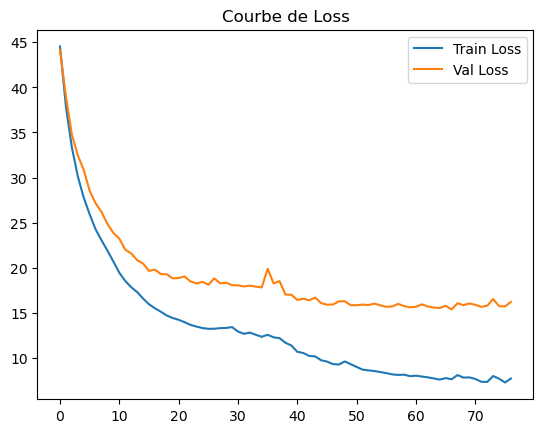

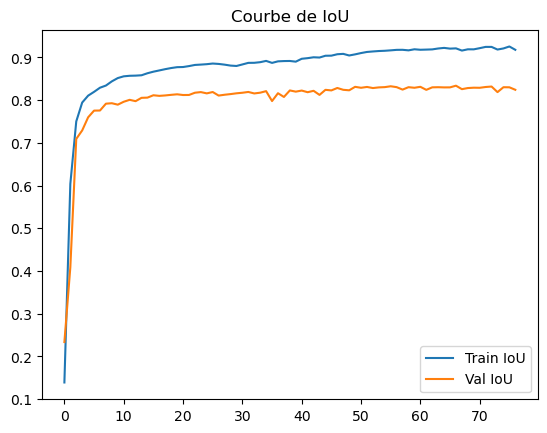

In [14]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Courbe de Loss")
plt.show()

# IoU ou autre métrique
if 'iou' in history.history:
    plt.plot(history.history['iou'], label='Train IoU')
    plt.plot(history.history['val_iou'], label='Val IoU')
    plt.legend()
    plt.title("Courbe de IoU")
    plt.show()

In [15]:
#loader function
def load_data(image_dir, mask_dir, img_size=(512, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255 # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks


In [16]:
#prep the prediction
test_images_path = "data/test/images"
test_masks_path = "data/test/gen_masks"

X_test, y_test = load_data(test_images_path, test_masks_path)
X_test.shape

(153, 512, 512, 3)

In [17]:
#prediction of trained model
prediction = model_augmented.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step


In [18]:
# Définir une palette de couleurs personnalisée pour 8 classes
colors = np.array([[128, 0, 128],     # Violet #"void"
                   [255, 0, 255],     # Magenta #"flat"
                   [0, 0, 255],       # Bleu #"construction"
                   [255, 255, 0],     # Jaune #"object"
                   [0, 255, 0],       # Vert #"nature"
                   [0, 255, 255],     # Cyan #"sky"
                   [255, 0, 0],       # Rouge #"human"
                   [255, 165, 0]],    # Orange #"vehicle"
                  dtype=np.uint8)


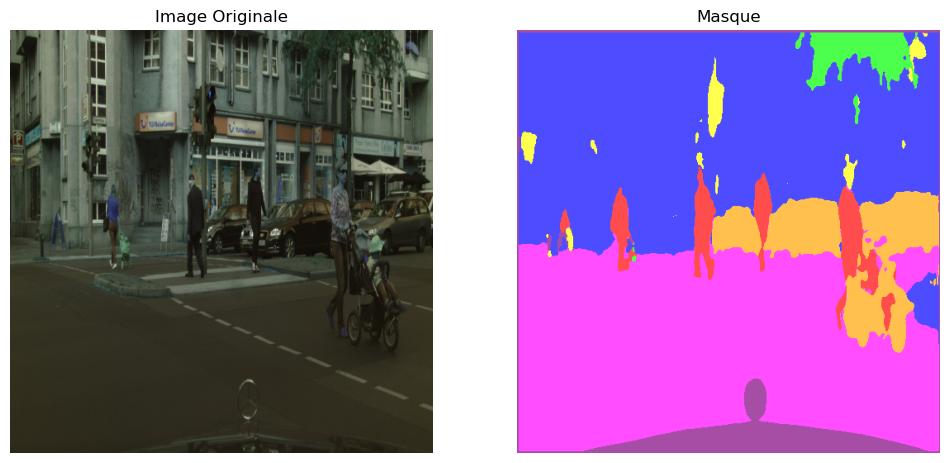

In [63]:
# for i the index of image to check
i = 1
mask_array = prediction[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

'''# Charger le mask original avec OpenCV
original_mask_path = os.path.join(test_masks_path,os.listdir(test_masks_path)[i])
original_mask = cv2.imread(original_mask_path)

#convert gt_mask to mask size
original_mask = cv2.resize(original_mask, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
gt_mask_channel = (original_mask * 255).astype(np.uint8) #prepare for individual inspection
gt_mask_index = np.argmax(original_mask, axis=-1) 
# Convertir le masque en image OpenCV
gt_mask_image = (gt_mask_index * 255).astype(np.uint8) 

# Créer un masque couleur en utilisant la palette
gt_color = colors[gt_mask_index]'''

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

'''#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[2].imshow(gt_color) #whole mask
axes[2].set_title("Ground_truth Mask")
axes[2].axis('off')
'''
plt.show()

#print(original_image.shape, mask_color.shape, original_mask.shape)

In [39]:
model_augmented.save('models_in_progress/inception_aug.keras')

In [53]:
#same for val set
image_dir_val = 'data/val/images'
mask_dir_val = 'data/val/gen_masks'
X_val, y_val = load_data(image_dir_val, mask_dir_val, num_classes=8)

In [57]:
result_Augmented_Inception = model_augmented.evaluate(val_dataset, return_dict=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9204 - iou: 0.8532 - loss: 14.6630


In [59]:
Augmented_Inception_train_time = t1
result_Augmented_Inception["train_time"] = Augmented_Inception_train_time
result_df = pd.DataFrame.from_dict(result_Augmented_Inception, orient='index')
print(result_df)

                       0
accuracy        0.909055
iou             0.833718
loss           15.363238
train_time  32234.654408
